In [1]:
# import necessary module 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from array_response import *

In [2]:
Ns = 1 # number of streams

Nc = 5 # number of cluster
Nray = 10 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


In [3]:
# test kronecker product
a = np.array([[1,2,3],[4,5,6]])
b = np.eye(2)
np.kron(a,b)

array([[ 1.,  0.,  2.,  0.,  3.,  0.],
       [ 0.,  1.,  0.,  2.,  0.,  3.],
       [ 4.,  0.,  5.,  0.,  6.,  0.],
       [ 0.,  4.,  0.,  5.,  0.,  6.]])

In [4]:
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)

At = array_response(0.2,0.3,Nt)
Ar = array_response(0.3,0.4,Nr)
At = At.reshape(-1,1)
Ar = Ar.reshape(-1,1)
test = Ar@At.conj().T
# print(test.shape)


In [5]:
H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
#         alpha_hh = np.random.normal(0, np.sqrt(sigma/2)) + 1j*np.random.normal(0, np.sqrt(sigma/2))
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H[:,:,reali] = H[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H[:,:,reali] = gamma* H[:,:,reali]


In [6]:
channel_fro = np.zeros(realization)
for reali in range(realization):
    channel_fro[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro**2))

4*Nt*Nr = 4096    Frobenius norm = 4161.43219687


In [7]:
print(4096/518.9)
print(4*16/5)
print(12.8/7.9)

7.893621121603392
12.8
1.620253164556962


In [8]:
alpha_hh.shape

(50, 1000)

(array([  4.,   3.,   7.,  10.,   6.,   9.,   7.,   2.,   0.,   2.]),
 array([ 0.01737711,  0.01808966,  0.0188022 ,  0.01951475,  0.0202273 ,
         0.02093984,  0.02165239,  0.02236494,  0.02307749,  0.02379003,
         0.02450258]),
 <a list of 10 Patch objects>)

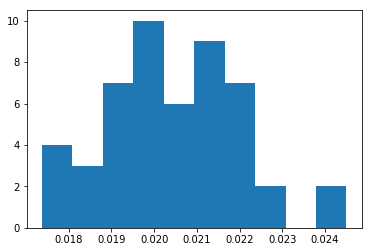

In [17]:
plt.hist(np.var(alpha_hv,axis=1))

In [10]:
AoA.shape

(2, 50)